# Project: Amazon Food Review Classification Problem

### Problem Description

sentimental analysis on Amazon Food Review dataset

dataset link:https://www.kaggle.com/snap/amazon-fine-food-reviews?select=Reviews.csv

### Import Packages

In [10]:
# Add environment Packages paths to conda
import os, sys
# env_name = "food_review"
# sys.path.append(f"C:\\Environments\\{env_name}\\lib\\site-packages\\")

import pandas as pd
import numpy as np

# Text preprocessing packages
import nltk # Text libarary
nltk.download('stopwords')

import string # Removing special characters {#, @, ...}
import re # Regex Package
from nltk.corpus import stopwords # Stopwords

nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

nltk.download('wordnet')
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wessa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wessa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wessa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Read Dataset

In [11]:
%%time
df = pd.read_csv('Reviews.csv')

Wall time: 3.32 s


In [12]:
f"{df.shape[0]:,} Review"

'568,454 Review'

In [13]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Drop Duplicates
Save the Cleaned data-frame also with the variable `df_text`

In [14]:
df_text = df_text.drop_duplicates()

In [15]:
df_text

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5
...,...,...
568449,Great for sesame chicken..this is a good if no...,5
568450,I'm disappointed with the flavor. The chocolat...,2
568451,"These stars are small, so you can give 10-15 o...",5
568452,These are the BEST treats for training and rew...,5


### Target Variable Pre-Processing
`target` will be 
 - 0 if score < 3 
 - 1 otherwise

In [17]:
df_text['target'] = np.where(df_text['Score'] < 3, 0, 1)

#### Plot Countplot for target Variable

<AxesSubplot:xlabel='target', ylabel='count'>

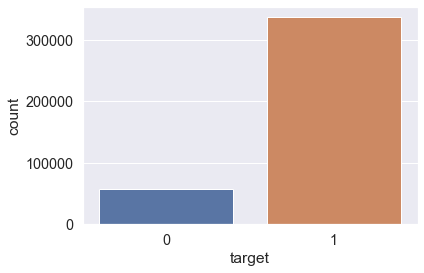

In [19]:
sns.countplot(x="target", data=df_text)

Notice how such variance is huge ...   
Then we need to down-sample such data ... by which both the positive and negative classes are balanced.

### Balance Data Target

In [21]:
df_text = df_text.reset_index(drop=True)

In [22]:
# Sample from positive reviews Same number of negative reviews
NEG_N = df_text.target.value_counts()[0]
df_pos = df_text[df_text['target'] == 1]['Text'].sample(NEG_N, replace=False)
df_text_balanced = pd.concat([df_text.iloc[df_pos.index], df_text[df_text.target == 0]])

<AxesSubplot:xlabel='target', ylabel='count'>

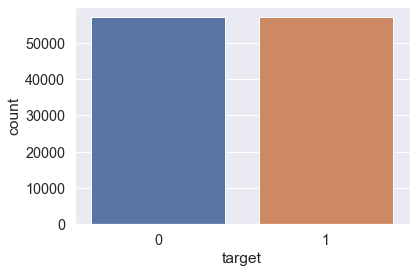

In [23]:
## PLot the target again after balancing
sns.countplot(x="target", data=df_text_balanced)

### Text Pre-Processing

In [24]:
df_text_balanced = df_text_balanced.reset_index(drop=True)
df_text_balanced

,Text,Score,target
0,My son was delighted to receive this as a gift...,5,1
1,While on jury duty for two weeks I packed a ha...,5,1
2,"I got 2 of these plants, 1 came slightly damag...",4,1
3,i am enjoying this tea very much. i have allow...,5,1
4,My wife and I tried so many different types of...,5,1
...,...,...,...
114163,I just bought this soup today at my local groc...,1,0
114164,This soup is mostly broth. Although it has a k...,2,0
114165,"It is mostly broth, with the advertised 3/4 cu...",2,0
114166,I had ordered some of these a few months back ...,2,0


## Normalizing

In [25]:
df_text_balanced["Text_Clean"] = df_text_balanced["Text"].str.lower().apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem)).apply(lambda elem: re.sub(r"\d+", "", elem))
df_text_balanced.head()

,Text,Score,target,Text_Clean
0,My son was delighted to receive this as a gift...,5,1,my son was delighted to receive this as a gift...
1,While on jury duty for two weeks I packed a ha...,5,1,while on jury duty for two weeks i packed a ha...
2,"I got 2 of these plants, 1 came slightly damag...",4,1,i got of these plants came slightly damaged ...
3,i am enjoying this tea very much. i have allow...,5,1,i am enjoying this tea very much i have allowe...
4,My wife and I tried so many different types of...,5,1,my wife and i tried so many different types of...


## removing stop words

In [26]:
stop = stopwords.words('english')
df_text_balanced['Text_Clean'] = df_text_balanced['Text_Clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_text_balanced.head()

,Text,Score,target,Text_Clean
0,My son was delighted to receive this as a gift...,5,1,son delighted receive gift christmas awhile ba...
1,While on jury duty for two weeks I packed a ha...,5,1,jury duty two weeks packed half cup baggie nib...
2,"I got 2 of these plants, 1 came slightly damag...",4,1,got plants came slightly damaged recovered inc...
3,i am enjoying this tea very much. i have allow...,5,1,enjoying tea much allowed friends try well com...
4,My wife and I tried so many different types of...,5,1,wife tried many different types cereal every t...


## Stemming

### create tokens

In [27]:
df_text_balanced['Tokens'] = df_text_balanced['Text_Clean'].apply(lambda x: word_tokenize(x))
df_text_balanced.head()

,Text,Score,target,Text_Clean,Tokens
0,My son was delighted to receive this as a gift...,5,1,son delighted receive gift christmas awhile ba...,"[son, delighted, receive, gift, christmas, awh..."
1,While on jury duty for two weeks I packed a ha...,5,1,jury duty two weeks packed half cup baggie nib...,"[jury, duty, two, weeks, packed, half, cup, ba..."
2,"I got 2 of these plants, 1 came slightly damag...",4,1,got plants came slightly damaged recovered inc...,"[got, plants, came, slightly, damaged, recover..."
3,i am enjoying this tea very much. i have allow...,5,1,enjoying tea much allowed friends try well com...,"[enjoying, tea, much, allowed, friends, try, w..."
4,My wife and I tried so many different types of...,5,1,wife tried many different types cereal every t...,"[wife, tried, many, different, types, cereal, ..."


### stemming words

In [28]:
def word_stemmer(text):
    stem_text = [SnowballStemmer("english").stem(i) for i in text]
    return stem_text

str = " "
df_text_balanced['Stemmed Words'] = df_text_balanced['Tokens'].apply(lambda x: word_stemmer(x)).apply(lambda x: str.join(x))
df_text_balanced.head()

,Text,Score,target,Text_Clean,Tokens,Stemmed Words
0,My son was delighted to receive this as a gift...,5,1,son delighted receive gift christmas awhile ba...,"[son, delighted, receive, gift, christmas, awh...",son delight receiv gift christma awhil back gi...
1,While on jury duty for two weeks I packed a ha...,5,1,jury duty two weeks packed half cup baggie nib...,"[jury, duty, two, weeks, packed, half, cup, ba...",juri duti two week pack half cup baggi nibbl b...
2,"I got 2 of these plants, 1 came slightly damag...",4,1,got plants came slightly damaged recovered inc...,"[got, plants, came, slightly, damaged, recover...",got plant came slight damag recov inch pot por...
3,i am enjoying this tea very much. i have allow...,5,1,enjoying tea much allowed friends try well com...,"[enjoying, tea, much, allowed, friends, try, w...",enjoy tea much allow friend tri well come back...
4,My wife and I tried so many different types of...,5,1,wife tried many different types cereal every t...,"[wife, tried, many, different, types, cereal, ...",wife tri mani differ type cereal everi time da...


### Split Test & Training Data

In [29]:
X = df_text_balanced["Stemmed Words"].copy()
y = df_text_balanced.target.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Text Embedding
 - Use `TfidfVectorizer`
 - `fit` on the training data only
 - `transform` on training and test 

In [30]:
## TFIDF embedding for the Description
vectorizer = TfidfVectorizer()
# fit on training (such vectorizer will be saved for deployment)
vectorizer_tfidf = vectorizer.fit(X_train)
# transform on training data
X_train = vectorizer.transform(X_train)
# transform on testing data
X_test = vectorizer.transform(X_test)

In [31]:
# See the dimensions of your data embeddings before entering to the model
X_train.shape, X_test.shape

((79917, 67445), (34251, 67445))

### Modelling

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

##### Sklearn framework steps
 - init
 - fit
 - predict

In [33]:
## initialize your Model
clf = RandomForestClassifier()
# Fit your Model on the Training Dataset
clf.fit(X_train,y_train)
# Predict on Test data
preds = clf.predict(X_test)
# Calculate Model Accuracy
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")

Model Accuracy = 84.16%


### Raw Instance Prediction

### cleanning review before

In [34]:
stemmer = SnowballStemmer("english")
stop = stopwords.words('english')

def cleaner(review):
    word_list = nltk.word_tokenize(review)
    clean_list = []
    for word in word_list:
        if word.lower() not in stop:
            stemmed = stemmer.stem(word)
            clean_list.append(stemmed)
    return " ".join(clean_list)

In [35]:
def raw_test(review, model, vectorizer):
    # Clean Review
    review_c = cleaner(review)
    # Embed review using tf-idf vectorizer
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction = model.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative"

In [36]:
review_1 = "That's a good Dish, Good Job"
raw_test(review_1, clf, vectorizer_tfidf)

'Positive'

In [37]:
review_2 = "That's the worst Dish ever tasted"
raw_test(review_2, clf, vectorizer_tfidf)

'Negative'

In [38]:
review_3 = "This dish is so good for me , it's too simple"
raw_test(review_3, clf, vectorizer_tfidf)

'Positive'

In [39]:
review_4 = "This dish is so dirty and i will damage it"
raw_test(review_4, clf, vectorizer_tfidf)

'Negative'

### Saving Models for Deployment

In [40]:
import pickle

In [41]:
model_name = 'rf_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'
model_path = os.path.join('/', model_name)
vect_path = os.path.join('/', vectorizer_name)

pickle.dump(clf, open(model_name, 'wb'))
pickle.dump(vectorizer, open(vectorizer_name, 'wb'))

### Load model Again and test them

In [42]:
loaded_model = pickle.load(open(model_name, 'rb'))
loaded_vect = pickle.load(open(vectorizer_name, 'rb'))

In [43]:
raw_test('very nice', loaded_model, loaded_vect)

'Positive'

In [44]:
raw_test("very bad", loaded_model, loaded_vect)

'Negative'